# Chapter 13 Exercise 10

Exercise: In this exercise you will download a dataset, split it, create a tf.data.Dataset to load it and preprocess it efficiently, then build and train a binary classification model containing an Embedding layer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import os

%matplotlib inline

## a.
Exercise: Download the Large Movie Review Dataset, which contains 50,000 movies reviews from the Internet Movie Database. The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise.

In [2]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

WindowsPath('C:/Users/nbwal/.keras/datasets/aclImdb')

In [3]:
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    " * indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)

aclImdb\
    README
    imdb.vocab
    imdbEr.txt
    test\
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg\
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos\
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train\
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        neg\
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos\
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup\
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...


In [4]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

## b. 
Exercise: Split the test set into a validation set (15,000) and a test set (10,000).

In [5]:
np.random.seed(42)

In [6]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

## c.
Exercise: Use tf.data to create an efficient dataset for each set.

In [7]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath, encoding='utf8') as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [8]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public a

In [9]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

## d.
Exercise: Create a binary classification model, using a TextVectorization layer to preprocess each review. If the TextVectorization layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the tf.strings package, for example lower() to make everything lowercase, regex_replace() to replace punctuation with spaces, and split() to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the adapt() method

In [10]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

In [11]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

In [12]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [13]:
text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int64)>

In [14]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

In [15]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 257,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 531, 334,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)>

In [16]:
text_vectorization.vocab[:10]

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

In [17]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

In [18]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [19]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

In [20]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1 # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

In [21]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 8s 9ms/step - loss: 0.5841 - accuracy: 0.6786 - val_loss: 0.5158 - val_accuracy: 0.7342
Epoch 2/5
782/782 [==============================] - 6s 8ms/step - loss: 0.4653 - accuracy: 0.7748 - val_loss: 0.5067 - val_accuracy: 0.7459
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.4107 - accuracy: 0.8099 - val_loss: 0.5160 - val_accuracy: 0.7392
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.3378 - accuracy: 0.8619 - val_loss: 0.5458 - val_accuracy: 0.7321
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 0.2527 - accuracy: 0.9111 - val_loss: 0.5885 - val_accuracy: 0.7306


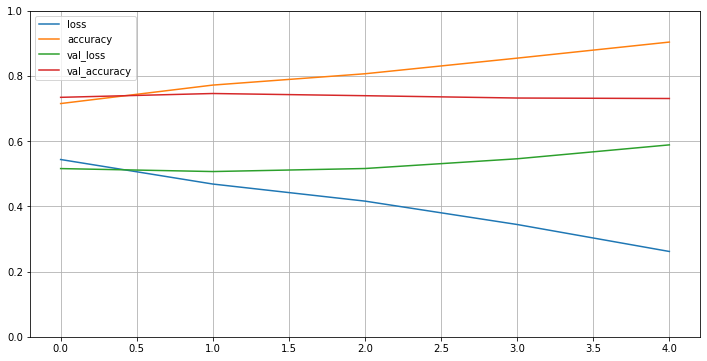

In [23]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## e.
Exercise: Add an Embedding layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model.

In [24]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_mean(inputs, axis=1) * sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2.3570225, 3.2998314, 1.4142135],
       [2.       , 0.       , 0.       ]], dtype=float32)>

In [25]:
tf.reduce_mean(another_example, axis=1) * tf.sqrt([[2.], [1.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2.3570225, 3.2998314, 1.4142135],
       [2.       , 0.       , 0.       ]], dtype=float32)>

## f.
Exercise: Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible.

In [26]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True), # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [28]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 3s 3ms/step - loss: 0.6045 - accuracy: 0.6647 - val_loss: 0.5176 - val_accuracy: 0.7355
Epoch 2/5
782/782 [==============================] - 2s 3ms/step - loss: 0.4990 - accuracy: 0.7511 - val_loss: 0.5139 - val_accuracy: 0.7396
Epoch 3/5
782/782 [==============================] - 2s 3ms/step - loss: 0.4845 - accuracy: 0.7614 - val_loss: 0.5107 - val_accuracy: 0.7408
Epoch 4/5
782/782 [==============================] - 2s 3ms/step - loss: 0.4796 - accuracy: 0.7642 - val_loss: 0.5095 - val_accuracy: 0.7409
Epoch 5/5
782/782 [==============================] - 2s 3ms/step - loss: 0.4734 - accuracy: 0.7679 - val_loss: 0.5148 - val_accuracy: 0.7416


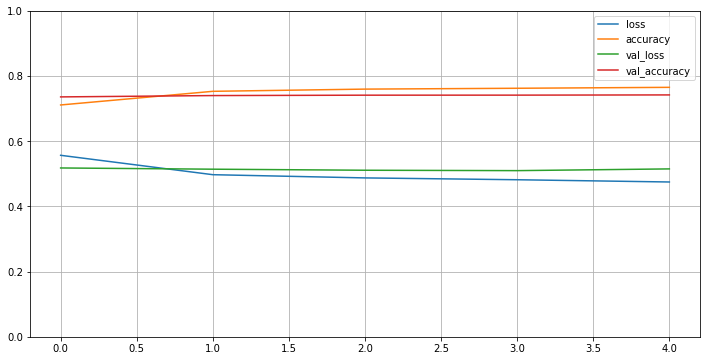

In [29]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## g.
Exercise: Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").

In [30]:
import tensorflow_datasets as tfds

In [31]:
datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

In [32]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
